# pycisTopic analysis

Full dataset, using SCREEN regions.

In [1]:
import pycisTopic

pycisTopic.__version__
%load_ext lab_black

In [2]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
import pickle
import pandas as pd

In [4]:
import glob
from collections import OrderedDict
import numpy as np

In [5]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/fixedcells_9_individual_malefemale_celltypefair


In [6]:
import os

wdir = "/lustre1/project/stg_00090/scatac_benchmark/fixedcells_9_individual_malefemale_celltypefair"
os.chdir(wdir)

In [7]:
cto_paths = sorted(glob.glob(f"male_female_celltypefaircto/*.pkl"))
cistopic_obj_path_dict = {x.split("/")[-1].split(f"_")[0]: x for x in cto_paths}
cistopic_obj_path_dict

{'10xmultiome': 'male_female_celltypefaircto/10xmultiome_malefemalecelltypefair.pkl',
 '10xv11': 'male_female_celltypefaircto/10xv11_malefemalecelltypefair.pkl',
 '10xv1': 'male_female_celltypefaircto/10xv1_malefemalecelltypefair.pkl',
 '10xv2': 'male_female_celltypefaircto/10xv2_malefemalecelltypefair.pkl',
 'ddseq': 'male_female_celltypefaircto/ddseq_malefemalecelltypefair.pkl',
 'hydrop': 'male_female_celltypefaircto/hydrop_malefemalecelltypefair.pkl',
 'mtscatac': 'male_female_celltypefaircto/mtscatac_malefemalecelltypefair.pkl',
 's3atac': 'male_female_celltypefaircto/s3atac_malefemalecelltypefair.pkl'}

In [8]:
n_topics_final = 40
base_topic = 10
topics_final = set(
    sorted([str(x + 1) for x in list(range(base_topic, n_topics_final))])
)
n_cores = 16
n_iter = "400"
print(sorted(topics_final))

['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']


In [9]:
mounts = "/lustre1,/staging,/data,/vsc-hard-mounts,/scratch"
sif = "../0_resources/cistopic_image/20220815_pycistopic.sif"
script = "../0_resources/scripts/runModels_lda_mallet.py"

f_mod_dir = "models__screen__mallet"
if not os.path.exists(os.path.join(wdir, f_mod_dir)):
    os.makedirs(os.path.join(wdir, f_mod_dir))

for sample in cistopic_obj_path_dict.keys():
    infile = cistopic_obj_path_dict[sample]
    outfile = os.path.join(f_mod_dir, sample + "__models_" + str(n_iter) + "_iter.pkl")

    intermediate_dir = f"{f_mod_dir}/model_intermediates/{sample}_model_intermediates/"

    if not os.path.exists(os.path.join(wdir, intermediate_dir)):
        os.makedirs(os.path.join(wdir, intermediate_dir))
    else:
        print(f"{intermediate_dir} already exists!")

    n_topics_detected = len(os.listdir(os.path.join(wdir, intermediate_dir)))
    if not n_topics_detected == n_topics_final:
        model_tmp_dir = f"{f_mod_dir}/model_tmp/{sample}_model_tmp/"
        if not os.path.exists(os.path.join(wdir, model_tmp_dir)):
            os.makedirs(os.path.join(wdir, model_tmp_dir))

        topics_detected = set(
            [
                x.replace("Topic", "").replace(".pkl", "")
                for x in os.listdir(os.path.join(wdir, intermediate_dir))
            ]
        )
        topics_todo = (
            str(sorted(list(topics_final - topics_detected)))
            .replace("'", "")
            .replace(" ", "")
            .replace("[", "")
            .replace("]", "")
        )
        ver = str(n_topics_final)

        if not topics_todo == "":
            out_log = f"{f_mod_dir}/{sample}.models_out_log{ver}.txt"
            cmd = f"echo {sample} && cd {wdir} && singularity exec -B {mounts} {sif} python {script} -i {infile} -o {outfile} -nt {topics_todo} -c {n_cores} -it {n_iter} -a 50 -abt True -e 0.1 -ebt False -sp {intermediate_dir} -s 555 -td {model_tmp_dir} > {out_log}"

            print(cmd)
            sh_path = f"{f_mod_dir}/{sample}.runmodels{ver}.sh"
            with open(sh_path, "w") as file:
                file.write("#!/bin/sh\n")
                file.write(cmd)
        else:
            print("All topics done.")

    print("\n")

models__screen__mallet/model_intermediates/10xmultiome_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/10xv11_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/10xv1_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/10xv2_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/ddseq_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/hydrop_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/mtscatac_model_intermediates/ already exists!
All topics done.


models__screen__mallet/model_intermediates/s3atac_model_intermediates/ already exists!
All topics done.




In shell:

```
for script in models__screen__mallet/*.sh
do
    echo $script
    sbatch -p --job-name=models --cluster=wice --partition=dedicated_big_bigmem -n 1 -A lp_big_wice_cpu --time=24:00:00 --ntasks=1 --cpus-per-task=24 --mem=300GB $script
done
```

In [64]:
ls models__screen__mallet/*.sh > models__screen__mallet/models.parallel
chmod 755 models__screen__mallet/*.sh
cat models__screen__mallet/models.parallel | parallel -j 5 --progress

SyntaxError: invalid syntax (2239788841.py, line 1)

ERROR:root:Cannot parse: 1:3: ls models__screen__mallet/*.sh > models__screen__mallet/models.parallel
Traceback (most recent call last):
  File "/opt/venv/lib/python3.8/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/opt/venv/lib/python3.8/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "src/black/__init__.py", line 1163, in format_str
  File "src/black/__init__.py", line 1173, in _format_str_once
  File "src/black/parsing.py", line 128, in lib2to3_parse
black.parsing.InvalidInput: Cannot parse: 1:3: ls models__screen__mallet/*.sh > models__screen__mallet/models.parallel


Then, combine the models:

In [10]:
# intermediate_dict = {x.split('/')[-2].split('_model_intermediates')[0]: x for x in sorted(glob.glob(f'{f_mod_dir}/model_intermediates/*/*'))}
# intermediate_dict

In [11]:
# file_list = sorted(glob.glob(f'{f_mod_dir}/model_intermediates/*/*'))
# n_topics = [int(x.split('Topic')[-1].split('.pkl')[0].replace('Topic','')) for x in file_list]
# file_list_sorted = [file_list[x] for x in np.argsort(n_topics)]

# models_merged = [pickle.load(open(file, 'rb')) for file in file_list_sorted]

In [12]:
# save_path = f"{f_mod_dir}/master_all_1.FIXEDCELLS__models_{n_iter}_iter.pkl"
# with open(save_path, "wb") as f:
#     pickle.dump(models_merged, f, protocol=4)

In [13]:
from pycisTopic.lda_models import evaluate_models
import matplotlib.pyplot as plt

In [24]:
cto_paths = sorted(
    glob.glob(f"male_female_celltypefaircto/*malefemalecelltypefair.pkl")
)
cistopic_obj_path_dict = {x.split("/")[-1].split(f"_")[0]: x for x in cto_paths}
cistopic_obj_path_dict

{'10xmultiome': 'male_female_celltypefaircto/10xmultiome_malefemalecelltypefair.pkl',
 '10xv11': 'male_female_celltypefaircto/10xv11_malefemalecelltypefair.pkl',
 '10xv1': 'male_female_celltypefaircto/10xv1_malefemalecelltypefair.pkl',
 '10xv2': 'male_female_celltypefaircto/10xv2_malefemalecelltypefair.pkl',
 'ddseq': 'male_female_celltypefaircto/ddseq_malefemalecelltypefair.pkl',
 'hydrop': 'male_female_celltypefaircto/hydrop_malefemalecelltypefair.pkl',
 'mtscatac': 'male_female_celltypefaircto/mtscatac_malefemalecelltypefair.pkl',
 's3atac': 'male_female_celltypefaircto/s3atac_malefemalecelltypefair.pkl'}

In [25]:
models_path_dict = {
    x.split("/")[-1].split(f"__models_{n_iter}_iter.pkl")[0]: x
    for x in sorted(glob.glob(f"{f_mod_dir}/*__models_{n_iter}_iter.pkl"))
}
models_path_dict

{'10xmultiome': 'models__screen__mallet/10xmultiome__models_400_iter.pkl',
 '10xv11': 'models__screen__mallet/10xv11__models_400_iter.pkl',
 '10xv1': 'models__screen__mallet/10xv1__models_400_iter.pkl',
 '10xv2': 'models__screen__mallet/10xv2__models_400_iter.pkl',
 'ddseq': 'models__screen__mallet/ddseq__models_400_iter.pkl',
 'hydrop': 'models__screen__mallet/hydrop__models_400_iter.pkl',
 'mtscatac': 'models__screen__mallet/mtscatac__models_400_iter.pkl',
 's3atac': 'models__screen__mallet/s3atac__models_400_iter.pkl'}

We need to minimize Arun, minimize Cao & Juan, maximize Mimno & maximize log likelihood

In [32]:
optimal_topics_dict = {
    "10xmultiome": 29,
    "10xv11": 29,
    "10xv1": 25,
    "10xv2": 30,
    "ddseq": 24,
    "hydrop": 29,
    "mtscatac": 26,
    "s3atac": 24,
}

In [33]:
for sample in models_path_dict.keys():
    if sample not in optimal_topics_dict.keys():
        print(f"adding {sample}")
        optimal_topics_dict[sample] = 15
    else:
        print(f"{sample} in optimal_topics_dict")

optimal_topics_dict

10xmultiome in optimal_topics_dict
10xv11 in optimal_topics_dict
10xv1 in optimal_topics_dict
10xv2 in optimal_topics_dict
ddseq in optimal_topics_dict
hydrop in optimal_topics_dict
mtscatac in optimal_topics_dict
s3atac in optimal_topics_dict


{'10xmultiome': 29,
 '10xv11': 29,
 '10xv1': 25,
 '10xv2': 30,
 'ddseq': 24,
 'hydrop': 29,
 'mtscatac': 26,
 's3atac': 24}

In [34]:
from pycisTopic.lda_models import evaluate_models
import matplotlib.pyplot as plt

10xmultiome
male_female_celltypefaircto/10xmultiome_malefemalecelltypefair.model_29topics.pkl
	Loaded models__screen__mallet/10xmultiome__models_400_iter.pkl, evaluating...


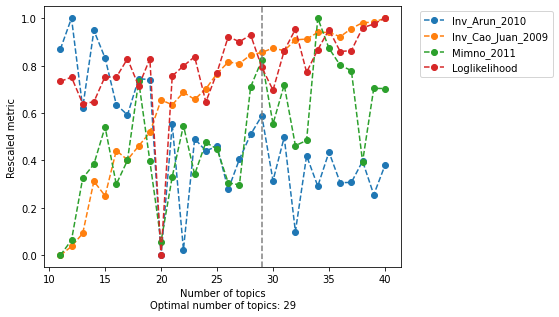

10xv11
male_female_celltypefaircto/10xv11_malefemalecelltypefair.model_29topics.pkl
	Loaded models__screen__mallet/10xv11__models_400_iter.pkl, evaluating...


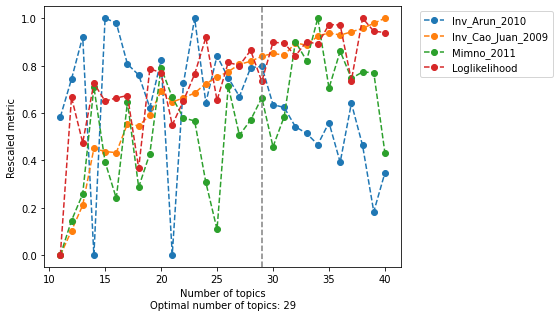

10xv1
male_female_celltypefaircto/10xv1_malefemalecelltypefair.model_25topics.pkl
	Loaded models__screen__mallet/10xv1__models_400_iter.pkl, evaluating...


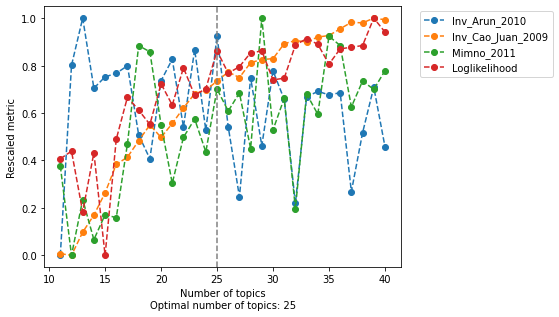

10xv2
male_female_celltypefaircto/10xv2_malefemalecelltypefair.model_30topics.pkl
	Loaded models__screen__mallet/10xv2__models_400_iter.pkl, evaluating...


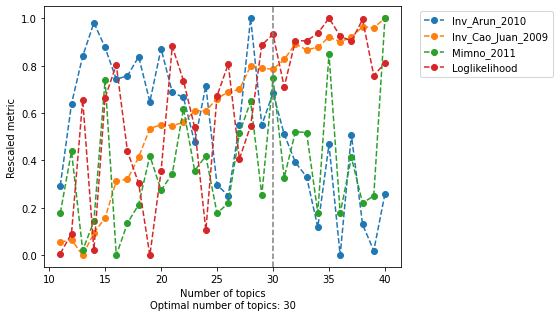

ddseq
male_female_celltypefaircto/ddseq_malefemalecelltypefair.model_24topics.pkl
	Loaded models__screen__mallet/ddseq__models_400_iter.pkl, evaluating...


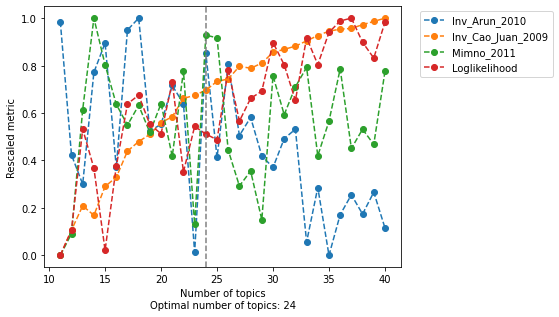

hydrop
male_female_celltypefaircto/hydrop_malefemalecelltypefair.model_29topics.pkl
	Loaded models__screen__mallet/hydrop__models_400_iter.pkl, evaluating...


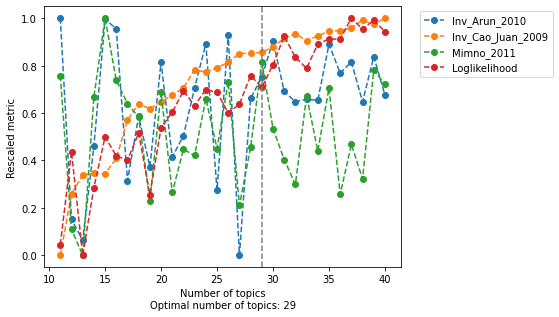

mtscatac
male_female_celltypefaircto/mtscatac_malefemalecelltypefair.model_26topics.pkl
	Loaded models__screen__mallet/mtscatac__models_400_iter.pkl, evaluating...


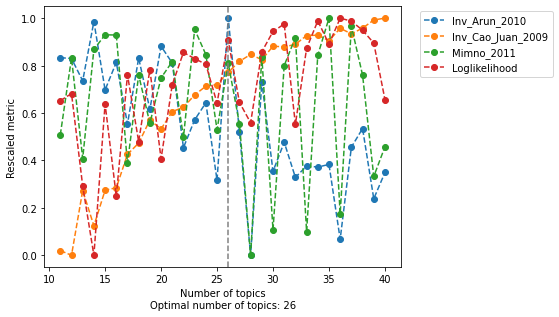

s3atac
male_female_celltypefaircto/s3atac_malefemalecelltypefair.model_24topics.pkl
	Loaded models__screen__mallet/s3atac__models_400_iter.pkl, evaluating...


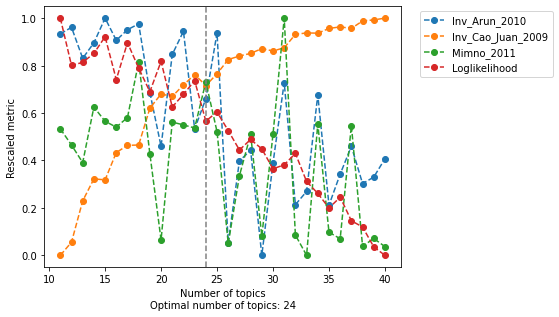

In [37]:
write = True
for sample in optimal_topics_dict.keys():
    # for sample in ['VIB_hydrop_2.FIXEDCELLS']:
    cto_path = cistopic_obj_path_dict[sample]
    print(sample)
    ntopics = optimal_topics_dict[sample]
    cto_path_new = cto_path.replace(".pkl", f".model_{ntopics}topics.pkl")
    print(cto_path_new)
    if not os.path.isfile(cto_path_new):
        if sample in list(models_path_dict.keys()):
            models_path = models_path_dict[sample]
            with open(models_path, "rb") as f:
                models = pickle.load(f)

            print(f"\tLoaded {models_path}, evaluating...")
            model = evaluate_models(
                models,
                select_model=optimal_topics_dict[sample],
                return_model=True,
                metrics=["Arun_2010", "Cao_Juan_2009", "Minmo_2011", "loglikelihood"],
                plot=True,  # disabled since we only test one model here
                plot_metrics=False,
                save=f"plots_qc/{sample}__model_evaluation.png",
            )

            if write == True:
                with open(cto_path, "rb") as f:
                    cto = pickle.load(f)

                cto.add_LDA_model(model)

                with open(cto_path_new, "wb") as f:
                    pickle.dump(cto, f, protocol=4)

        else:
            print(f"\t{sample} models does not exist!")
    else:
        print(f"\t{cto_path_new} already exists! Skipping...")

In [ ]:
{'10xmultiome': 29,
 '10xv11': 29,
 '10xv1': 25,
 '10xv2': 30,
 'ddseq': 24,
 'hydrop': 29,
 'mtscatac': 26,
 's3atac': 24}